# [HW12] Logistic Regression


우리는 지금까지 주어진 데이터와 가장 잘 맞는 직선을 찾는 linear regression을 진행하였습니다. 하지만 예측 값이 연속적인 값을 갖지 않는다면 어떻게 할까요? 

가장 대표적인 것은 binary classification 입니다. 이는 종류가 2개로 나뉘어진 데이터가 있고 이를 분류하는 문제입니다. 수많은 메일들 중에서 스팸인 메일과 스팸이 아닌 메일을 분류하는 것이 하나의 예시입니다. 이 문제는 예측 값이 연속적인 값이 아닌 0 또는 1입니다. 

이때는 우리의 예측 값을 확률 값으로 만든 다음에 확률 값이 우리의 기준보다 높으면 1, 아니면 0으로 분류합니다. 

이러한 문제를 푸는 방법을 logistic regression이라고 합니다. 



## 1.1 Logistic function

Logistic regression을 진행하기 위해서는 출력 값을 0과 1의 값으로 맞춰주어야 합니다. 이를 위해서 우리는 **logistic function** 을 사용합니다. Logistic function은 다음과 같습니다. 

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Logistic regression을 진행할 때 입력 데이터를 $x$, 실제 class 값을 $y$, 예측된 출력 값을 $\hat{y}$라고 하면 $x$는 두가지 변환을 거쳐서 $\hat{y}$가 됩니다. 
$$z = wx + b$$
$$\hat{y} = \sigma(z)$$
우리의 목표는 $\hat{y}$가 실제 $y$와 가장 가깝게 되도록 하는 $w$와 $b$를 찾는 것 입니다. 

Logistic function을 코드를 통해서 알아보도록 하겠습니다. 

In [3]:
import sympy
import numpy

from matplotlib import pyplot
%matplotlib inline

In [4]:
z = sympy.Symbol('z', real=True)

logistic = 1/(1+ sympy.exp(-z))
logistic

1/(1 + exp(-z))

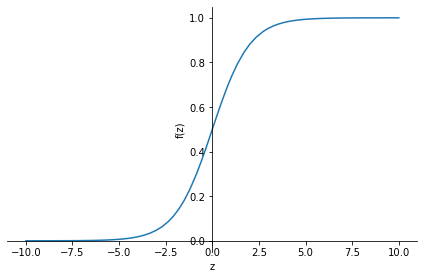

In [5]:
sympy.plotting.plot(logistic);

위 그래프를 보면 $z=0$ 일 때 출력 값이 0.5가 됩니다. 그리고 양수 일 때는 1에 가까워지고 음수일 때는 0으로 가까워지게 됩니다. 이렇게 $z$값을 0과 1 사이로 표현할 수 있게 되었습니다. 

이제 데이터를 직접 만들어서 진행해 보도록 하겠습니다. 

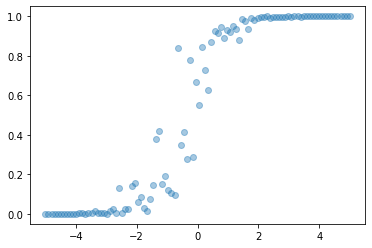

In [32]:
# synthetic data
x_data = numpy.linspace(-5, 5, 100)
w = 2
b = 1
numpy.random.seed(0)
z_data = w * x_data + b + numpy.random.normal(size=len(x_data))
y_data = 1 / (1+ numpy.exp(-z_data))

pyplot.scatter(x_data, y_data, alpha=0.4);

이번에도 [HW10]에서 진행한 것과 같이 조금의 noise를 추가해서 데이터를 생성하였습니다. 

이제 실제 class 값을 정해주어야 합니다. Numpy 패키지 안의 where 함수로 0.5 보다 큰 값을 1, 작은 값을 0으로 class를 부여해 주겠습니다. 

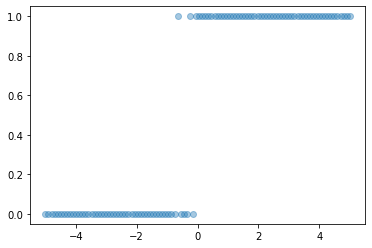

In [33]:
y_data = numpy.where(y_data >= 0.5, 1, 0)
pyplot.scatter(x_data, y_data, alpha=0.4);

## 1.2 Logistic loss function

$\hat{y}$가 실제 $y$와 가장 가깝게 되도록 하는 $w$와 $b$를 찾으려면 우리는 cost function을 정의해야 합니다. 

Linear regression 문제를 해결할 때는 mean square error를 사용했습니다. 

하지만 logistic regression에 적용하면 문제가 생깁니다. 

기존의 linear regression에서의 mean square error 에서는 

$$\frac{1}{n} \sum_{i=1}^n (y_i - (wx_i + b))^2$$

의 형태를 이루고 있어서 convex 한 형태를 이루고 있었습니다. 

그런데 logistic function을 포함한 logistic regression에서는 

$$\frac{1}{n} \sum_{i=1}^n (y_i - \sigma(wx_i + b))^2$$

$\sigma$인 logistic function 때문에 더이상 convex 한 형태가 아닙니다. 예시를 통해서 왜 convex가 아닌지 알아보겠습니다. 

간단한 예시를 위해 $w = 1, b=0$일 때 3개의 데이터를 통해서 알아보겠습니다.

$(x, y) : (-1, 2), (-20, -1), (-5, 5)$ 일 때 cost function을 그래프로 나타내면 다음과 같습니다.    

In [7]:
badloss = (2 - 1/(1+ sympy.exp(-z)))**2 + \
          (-1 - 1/(1+ sympy.exp(-20*z)))**2  + \
          (5 - 1/(1+ sympy.exp(-5*z)))**2
badloss

(-1 - 1/(1 + exp(-20*z)))**2 + (2 - 1/(1 + exp(-z)))**2 + (5 - 1/(1 + exp(-5*z)))**2

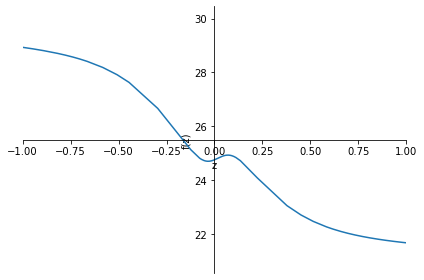

In [8]:
sympy.plotting.plot(badloss, xlim=(-1,1));

Gradient descent 방식으로 위 cost function의 최솟값을 구하게 되면 중간에 기울기가 0인 지점에서 멈추게 되고, 우리는 원하는 가장 작은 값에 도달하지 못하고 local minimum에 도달하게 됩니다. 



그래서 mean square error말고 다른 방법을 찾기 위해 cost function의 의미를 다시 한번 생각해 보겠습니다. 

우리가 어떤 값을 예측할 때 많이 틀렸다면, 예측하는데 쓰인 변수들을 많이 바꾸어야 합니다. 그에 비해 조금 틀렸다면, 이미 잘 예측하고 있기 때문에 변수들을 조금 바꾸어야 합니다. 많이 바꾸고, 조금 바꾸는 것은 기울기의 크기가 정합니다. 이러한 원리를 사용해서 linear regression에서는 square error를 쓰는 것입니다. 

이 원리를 logistic regression에도 적용해 보겠습니다. 

$z = wx + b$ 일 때 cost function $L$을 b에 대해서 미분을 해보겠습니다. Chain rule을 사용하면 다음과 같게 됩니다. 

$$\frac{\partial{L}}{\partial{b}} = \frac{\partial{L}}{\partial{\sigma(z)}} \frac{\partial{\sigma(z)}}{\partial{z}}\frac{\partial{z}}{\partial{b}}$$

이 때 $\frac{\partial{z}}{\partial{b}}$는 1이 돼서 사라집니다. 

이제 $\frac{\partial{\sigma(z)}}{\partial{z}}$에 대해서 알아보겠습니다. 

In [9]:
lprime = logistic.diff(z)
lprime

exp(-z)/(1 + exp(-z))**2

위에서 나온 $\sigma'(z)$를 정리를 해보겠습니다. 


$$\frac{\partial{\sigma(z)}}{\partial{z}} = \frac{e^{-z}}{(1+e^{-z})^2} = \frac{1}{1+e^{-z}} \times \frac{e^{-z}}{1+e^{-z}} = \sigma(z)\times \frac{e^{-z}}{1+e^{-z}} $$
가 되고, 여기서 $\frac{e^{-z}}{1+e^{-z}} $를 다시 정리해보면 다음과 같습니다. 

$$\frac{e^{-z}}{1+e^{-z}} = \frac{1 + e^{-z} -1}{1 + e^{-z}} = 1 - \frac{1}{1+e^{-z}} = 1-\sigma(z)$$

결론적으로, 
$$\sigma'(z) = \sigma(z) ( 1 - \sigma(z))$$
가 됩니다. 


다시한번 위 식을 정리해보면 다음과 같습니다. 


$$\frac{\partial{L}}{\partial{b}} = \frac{\partial{L}}{\partial{\sigma(z)}} \frac{\partial{\sigma(z)}}{\partial{z}} = \frac{\partial{L}}{\partial{\sigma(z)}} \sigma(z) (1-\sigma(z))$$

여기서 우리는 $\frac{\partial{L}}{\partial{b}}$의 값이 예측 값과 실제 값의 차이가 클수록 크고, 작을수록 작게 하고 싶기 때문에 $\frac{\partial{L}}{\partial{b}} = (y - \sigma(z))$로 정의하겠습니다. 정리하면 다음과 같습니다. 

$$\frac{\partial{L}}{\partial{\sigma(z)}} = \frac{(y-\sigma(z))}{\sigma(z)(1-\sigma(z))}$$

이제 위 식을 $L$에 대해서 코드를 통해서 정리해보겠습니다. 코드를 간단히 하기 위해서 $\sigma(z) = a$라고 치환해서 생각하겠습니다. 

In [10]:
a, y = sympy.symbols('a y', real=True)

In [11]:
dLda = (y-a)/a/(1-a)
dLda

(-a + y)/(a*(1 - a))

In [12]:
L = sympy.integrate(dLda, a)
L

y*log(a) + (1 - y)*log(a + (1 - 2*y)/(2*y - 1))

In [13]:
sympy.simplify(L)

y*log(a) - (y - 1)*log(a - 1)

여기서 $a = \sigma(z)$이기 때문에 $ a < 1 $이 됩니다. 그래서 $\log$ 안의 값이 음수가 되면 안되기 때문에 식을 변환해 줍니다. 

In [14]:
L = -y*sympy.log(a) + (y-1)*sympy.log(1-a)
L

-y*log(a) + (y - 1)*log(1 - a)

우리가 구한 cost function $L$은 
$L = -y \log(a) + (y-1)\log(1-a)$이 됩니다. 

이제 실제로 차이가 클 때 $L$값이 커지는지 알아보도록 하겠습니다. 


먼저 만약 $y=1$이라면 $L = -\log(a)$만 남게 됩니다. 그래프로 표현하면 다음과 같습니다. 

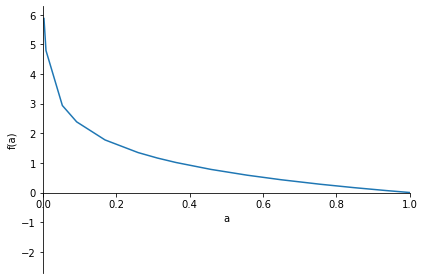

In [15]:
sympy.plotting.plot(-sympy.log(a), xlim=(0,1));

실제 class 가 1일 때 예측 값이 0에 가까워지면 cost function값이 커지고, 1에 가까워지면 cost function이 작아지는 것을 알 수 있습니다. 이는 우리가 원래 목표했던 것과 동일합니다. 

이제 $y=0$이라면 $L = \log(1-a)$ 만 남게 됩니다. 이를 또한 그래프로 표현하면 다음과 같습니다. 

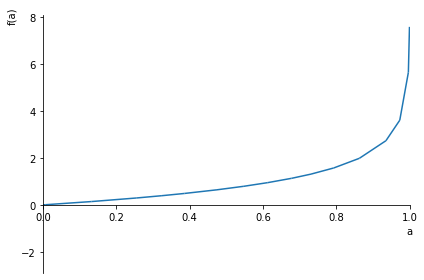

In [ ]:
sympy.plotting.plot(-sympy.log(1-a), xlim=(0,1));

이번에도 예측값이 실제 값이랑 가까워지면 cost function값이 작아지고 멀어지면 커지게 됨을 알 수 있습니다. 

## 1.3 Find the parameters using autograd function

이제 logistic regression의 전체적인 과정을 코드를 통해서 알아보도록 하겠습니다. 

In [16]:
logistic

1/(1 + exp(-z))

In [17]:
w, b, x, y = sympy.symbols('w b x y')
logistic = 1/(1+ sympy.exp(-w*x-b)) # redefined with the composition

Loss = -y*sympy.log(logistic) - (1-y)*sympy.log(1-logistic)
Loss

-y*log(1/(exp(-b - w*x) + 1)) - (1 - y)*log(1 - 1/(exp(-b - w*x) + 1))

지금까지 diff 를 통해서 기울기를 구했습니다. 그런데 식이 복잡해질수록 속도가 느려지기 때문에 autograd를 통해서 구해보겠습니다. 

In [19]:
# import the autograd-wrapped version of numpy
from autograd import numpy

In [18]:
# import the gradient calculator
from autograd import grad 

In [27]:
# note: the namespace numpy is the autograd wrapper to NumPy

def logistic(z):
    '''The logistic function'''
    return 1 / (1 + numpy.exp(-z))
    
def logistic_model(params, x):
    '''A prediction model based on the logistic function composed with wx+b
    Arguments:
       params: array(w,b) of model parameters
       x :  array of x data'''
    w = params[0]
    b = params[1]
    z = w * x + b
    y = logistic(z)
    return y

def log_loss(params, model, x, y):
    '''The logistic loss function
    Arguments:
       params: array(w,b) of model parameters
       model:  the Python function for the logistic model
       x, y:   arrays of input data to the model'''
    y_pred = model(params, x)
    return -numpy.mean(y * numpy.log(y_pred) + (1-y) * numpy.log(1 - y_pred))

In [28]:
# get a function to compute the gradient of the logistic loss
gradient = grad(log_loss)

In [29]:
type(gradient)

function

이 떄 grad 함수는 변수 개수만큼 output을 만들게 됩니다. 우리는 $w, b$ 2개의 변수가 있습니다. 먼저 예시로 랜덤으로 초기화한 변수를 넣어서 기울기값을 구해보겠습니다. 

In [30]:
numpy.random.seed(0)
params = numpy.random.rand(2)
print(params)

[0.5488135  0.71518937]


In [34]:
gradient(params, logistic_model, x_data, y_data)

array([-0.42734877,  0.08274066])

이렇게 2개의 변수에 대해서 각각 기울기 값을 반환해줍니다. 

이번에 gradient descent 를 진행할 때는 새로운 조건을 추가해서 진행하겠습니다. 우리가 정한 반복 수 외의 기울기 값이 0에 가까워지면 더이상 반복을 하지 않는 조건을 추가하겠습니다. 0에 가까운 값을 설정한 뒤 그것보다 작아지면 while 문이 멈추도록 설정하여서 gradient descent 를 진행하겠습니다. 

Optimized value of w is 3.9605082723788887 vs. true value: 2
Optimized value of b is 1.1306283025398258 vs. true value: 1
Exited after 5000 iterations


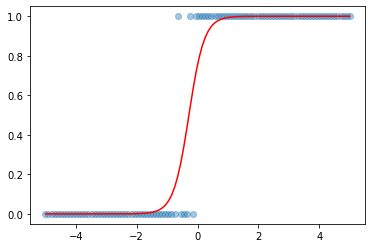

In [38]:
max_iter = 5000
i = 0
descent = numpy.ones(len(params))

while numpy.linalg.norm(descent) > 0.001 and i < max_iter:

    descent = gradient(params, logistic_model, x_data, y_data)
    params = params - descent * 0.01
    i += 1


print('Optimized value of w is {} vs. true value: 2'.format(params[0]))
print('Optimized value of b is {} vs. true value: 1'.format(params[1]))
print('Exited after {} iterations'.format(i))


pyplot.scatter(x_data, y_data, alpha=0.4)
pyplot.plot(x_data, logistic_model(params, x_data), '-r');

빨간색 곡선이 우리의 모델입니다. 

이제 기준값을 정하고 그것보다 크면 1, 작으면 0으로 분류를 하면 됩니다. 

이번에는 0.5로 설정해서 진행하겠습니다. 

In [39]:
def decision_boundary(y):
    return 1 if y >= .5 else 0

모든 점을 함수에 넣어야 하는데 하나씩 넣으면 반복문을 돌아야해서 오래걸리기 때문에 numpy의 vectorize 함수를 사용하겠습니다. 

In [40]:
decision_boundary = numpy.vectorize(decision_boundary)

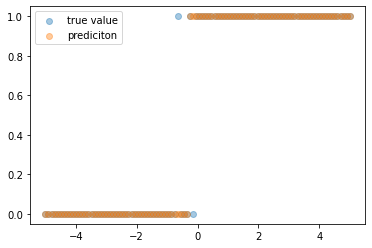

In [41]:
def classify(predictions):
    '''
    Argument:
    predictions, an array of values between 0 and 1
    
    Returns: 
    classified, an array of 0 and 1 values'''

    return decision_boundary(predictions).flatten()

pyplot.scatter(x_data, y_data, alpha=0.4,
               label='true value')
pyplot.scatter(x_data, classify(logistic_model(params, x_data)), alpha=0.4, 
               label='prediciton')

pyplot.legend();

거의 모든 데이터들을 정확하게 예측한 것을 알 수 있습니다.

이번 시간에는 직접 데이터를 만들어서 간단한 logistic regression 문제를 해결해 보았습니다. 

질문 있으면 편하게 해주세요~